In [1]:
!kaggle datasets download jp797498e/twitter-entity-sentiment-analysis -p dataset
!unzip dataset/twitter-entity-sentiment-analysis.zip -d dataset

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/1.99M [00:00<?, ?B/s]
100% 1.99M/1.99M [00:00<00:00, 106MB/s]
Archive:  dataset/twitter-entity-sentiment-analysis.zip
  inflating: dataset/twitter_training.csv  
  inflating: dataset/twitter_validation.csv  


In [2]:
import pandas as pd
from nltk.stem import PorterStemmer
import nltk
import string
import numpy as np
from sentence_transformers import SentenceTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
model_name="all-MiNiLM-L6-v2"
model_encode=SentenceTransformer(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [4]:
data=pd.read_csv("/content/dataset/twitter_training.csv",header=None)
data.rename(columns={0: 'Id', 1: 'Company',2:'Sentiment',3:'Comment'}, inplace=True)
data.drop(columns=['Id','Company'],inplace=True)
data.dropna(inplace=True)

In [5]:
st=PorterStemmer()
def preprocess(text):
    x=" ".join([st.stem(x) for x in text.split()])
    x=x.translate(str.maketrans('','',string.punctuation))
    return x

In [6]:
st=PorterStemmer()
x=data["Comment"][:1000]
y=data["Sentiment"][:1000]
x=x.map(preprocess)

In [7]:
x=x.map(lambda x:model_encode.encode(x))
x=np.array(x)
x=np.stack(x)
x = x.reshape((x.shape[0], 1, x.shape[1]))

In [8]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
num_classes = len(np.unique(y_encoded))
y_categorical = to_categorical(y_encoded, num_classes=num_classes)

In [11]:
y_categorical.shape

(1000, 4)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x, y_categorical, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(x.shape[1], x.shape[2])),
    Dropout(0.3),
    BatchNormalization(),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model.summary
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

Epoch 1/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 34s 15ms/step - accuracy: 0.4748 - loss: 1.2079 - val_accuracy: 0.5722 - val_loss: 1.0248
Epoch 2/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 39s 14ms/step - accuracy: 0.5608 - loss: 1.0540 - val_accuracy: 0.5899 - val_loss: 0.9766
Epoch 3/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.5840 - loss: 1.0012 - val_accuracy: 0.6103 - val_loss: 0.9306
Epoch 4/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.6117 - loss: 0.9503 - val_accuracy: 0.6322 - val_loss: 0.8913
Epoch 5/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 26s 14ms/step - accuracy: 0.6250 - loss: 0.9164 - val_accuracy: 0.6533 - val_loss: 0.8529
Epoch 6/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.6468 - loss: 0.8711 - val_accuracy: 0.6675 - val_loss: 0.8186
Epoch 7/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.6668 - loss: 0.8308 - val_accuracy: 0.6897 - val_loss: 0.7838
Epoch 8/50
1850/1850 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.6860 -

In [ ]:
model.save("model.keras")

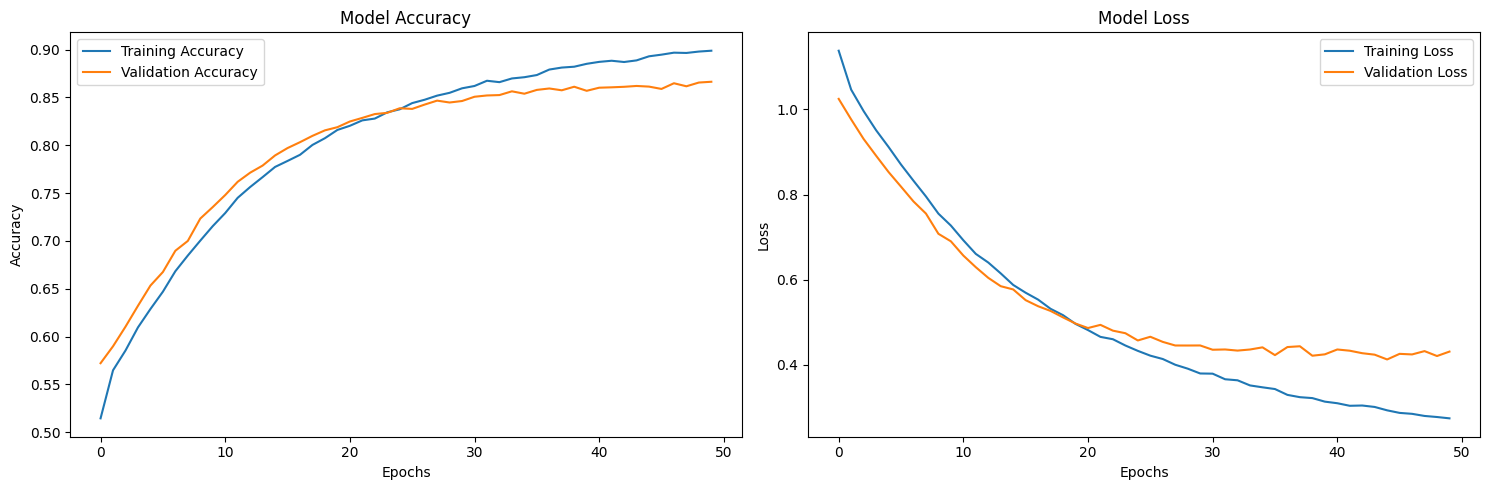

In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(history.history['accuracy'], label='Training Accuracy')
axs[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[1].plot(history.history['loss'], label='Training Loss')
axs[1].plot(history.history['val_loss'], label='Validation Loss')
axs[1].set_title('Model Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
def predict_class(text):
    vector = model_encode.encode(text)
    vector = vector.reshape((1, 1, 384))
    probs = model.predict(vector)
    class_index = np.argmax(probs)
    class_label = le.inverse_transform([class_index])[0]
    return class_label, probs[0]

In [ ]:
from google.colab import files
files.download("/content/model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>